Integrantes:
- Sebastian Lopez
- Mateo Tapia

# 1. Interpretación de métricas


### Explica con tus propias palabras qué representan P (precisión) y R (recall) y cómo interpretar sus valores en la Tabla I.
- Precisión (P): responde a la pregunta "De todas las detecciones que hizo el modelo, ¿cuántas eran correctas?". Un valor alto indica que el modelo rara vez se equivoca cuando dice haber encontrado un objeto (pocos falsos positivos).

- Recall (R): responde a la pregunta "De todos los objetos que realmente existían en la imagen, ¿cuántos encontró el modelo?". Un valor alto indica que al modelo no se le escapan los objetos (pocos falsos negativos).

Interpretación en la Tabla 1:
Observamos un desbalance. Por ejemplo, para RBC, el Recall es alto pero la Precisión es baja. Esto significa que el modelo detecta la gran mayoría de glóbulos rojos, pero comete muchos errores (quizás confundiendo lo que en verdad esta detectando). En cambio, para WBC, la precisión es muy alta (0.908), lo que indica que es muy confiable cuando detecta uno.

###  Describe la diferencia entre mAP50 y mAP50-95 y por qué usamos ambos.
- mAP50: Evalúa si el modelo detectó el objeto correctamente considerando un umbral de superposición (IoU) del 50%. Nos dice principalmente si el modelo encontró el objeto y la caja está más o menos en su lugar.

- mAP50-95: Es el promedio de la precisión evaluada en múltiples umbrales de superposición, desde el 50% hasta el 95% en pasos de 0.05. Este métrica es mucho más estricta y evalúa qué tan perfectamente ajustada está la caja al objeto.

- Se usan ambos porque se complementan para mejorar la calidad del reconocimiento: usamos mAP50 para saber si el modelo es capaz de localizar los objetos de forma general (útil para comparación rápida), y usamos mAP50-95 para medir la calidad de la detección. Por ejemplo, un mAP50 alto con un mAP50-95 bajo indicaría que el modelo encuentra los objetos, pero dibuja cajas muy grandes o desplazadas.

### Analiza las Tablas I y II y responde: ¿en cuál experimento obtuvimos mejor desempeño global? Justifica tu elección.

El experimento de la Tabla 2 obtuvo un mejor desempeño global. Al observar la fila `all` que es el promedio de todas las clases, vemos que todas las métricas principales mejoraron significativamente comparandola con la primera tabla. Esto es especialmente bueno cuando vemos la mejora de mAP50 y mAP50-95, ya que indica que el segundo modelo no solo encuentra más objetos, sino que ajusta mejor las cajas.

### Centrándote solo en la clase Platelets, decide qué experimento es superior considerando P y R y explica por qué.

El experimento de la Tabla 2 obtuvo un mejor desempeño.

- En la Tabla I: P = 0.759, R = 0.817.
- En la Tabla II: P = 0.741, R = 0.929.

Aunque la Precisión cayó ligeramente, el Recall aumentó drásticamente (+0.112). En el contexto de deteccion médica, normalmente es preferible que el modelo encuentre todas las plaquetas (alto Recall) aunque cometa algún pequeño error extra, a que deje de detectar casi el 20% de ellas como pasaba en la Tabla 1. El intercambio de una pérdida de precisión por una ganancia grande en sensibilidad hace al segundo modelo mucho mejor para este contexto y clase.

# 2. Finetuning

Instalamos los paquetes requeridos y descomprimimos el dataset

In [27]:
!pip -q install ultralytics # Instalamos Ultralytics (nos permitirá usar YOLO)

pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.12.11
  3.13.7

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [28]:
!unzip -o datasets.zip # Descomprimimos el dataset

Archive:  datasets.zip
  inflating: datasets/BCCD/labels/train/BloodImage_00339.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00287.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00107.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00305.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00089.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00311.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00199.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00193.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00204.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00077.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00083.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00247.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00212.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00340.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00264.txt  
  inflating: datasets/BCCD/label

In [27]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

In [34]:
# Paquetes a usar
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import itertools
import polars as pl
import os
import matplotlib.pyplot as plt

Se hará un grid search como método exploratorio para finetunear el modelo según las restricciones y posibles modificaciones aprendidas en clase. En ese sentido, solo se cambiarán 4 parámetros de entrenamiento. A continuación se justifica cada parámetro incluido para el grid search:
- `freeze`: Como el dataset BCCD (células vistas en microscopio) tiene características visuales diferentes a las de COCO (objetos cotidianos), congelar las capas impide que el modelo aprenda formas y texturas celulares básicas. Al disminuir el freeze, permitimos que la red neuronal adapte sus pesos al dominio médico.
- `optimizer`: Se quiere implementar AdamW como una alternativa a SGD. SGD es robusto pero a veces es muy lento. AdamW suele converger más rápido y lograr mejores resultados en datasets pequeños y en pocas épocas.
- `lr0`: Un learning rate muy alto puede destruir los pesos pre-entrenados útiles, especialmente si lo combinamos con todos los otros cambios.
- `batch`: Variar el batch puede ayudar a actualizar más veces los pesos en caso se disminuya el valor, pero igual se intentará con un valor más grande también.


In [35]:
param_grid = {
    # Hiperparámetros a variar
    'freeze': [22, 10, 0],  # 22 (base), 10 (medio), 0 (se entrena todo)
    'optimizer': ['SGD', 'AdamW'],  # AdamW puede converger más rápido
    'lr0': [0.01, 0.001],  # Cambio del learning rate inicial
    'batch': [8, 16, 32],
}


In [36]:
BASE_PATH = Path().cwd()
OUTPUT_DIR = BASE_PATH.joinpath("runs", "detect")

In [37]:
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total de experimentos a correr: {len(combinations)}")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

Total de experimentos a correr: 36
Los resultados se guardarán en: /home/s.lopezmedina/Maestria/4_computer_vision/codigo/8_laboratorio_calificado_4/runs/detect


Se ejecuta el grid search. Los resultados obtenidos aqui luego seran procesados para ver la mejora obtenida sobre los resultados de la tabla 1 y 2 del laboratorio.

In [33]:
all_results = []

for i, config in enumerate(combinations):
    run_name = f"Grid_Exp_{i}"
    print(f"\n=== Iniciando {run_name} ===")

    model = YOLO("yolov8n.pt")

    # ENTRENAMIENTO
    model.train(
        data="bccd.yaml",
        epochs=50,
        imgsz=640,
        name=run_name,
        project=OUTPUT_DIR,  # Para generar especificamente los resultados en el directorio deseado
        patience=10,
        device=0,
        verbose=False,
        **config
    )

    # VALIDACIÓN
    # Usamos project también para que guarde los plots de validación ahí mismo
    metrics = model.val(split="val", verbose=False, project=OUTPUT_DIR, name=f"{run_name}_val")

    # Extraer métricas globales
    res = {
        'Experiment': run_name,
        **config,
        'mAP50': metrics.box.map50,
        'mAP50-95': metrics.box.map,
        'Precision': metrics.box.mp,
        'Recall': metrics.box.mr
    }

    # Extraer métricas por clase
    class_maps = metrics.box.maps
    for class_id, class_name in model.names.items():
        res[f"{class_name}_mAP95"] = class_maps[class_id]

    all_results.append(res)

    # Guardar CSV parcial en la ruta base
    csv_path = BASE_PATH / "resultados_parciales_gridsearch.csv"
    pd.DataFrame(all_results).to_csv(csv_path, index=False)

# RESULTADOS FINALES
df = pd.DataFrame(all_results)
df = df.sort_values(by="mAP50-95", ascending=False)
final_csv_path = BASE_PATH / "resultados_finales_gridsearch.csv"
df.to_csv(final_csv_path, index=False)

print(f"\nProceso finalizado. CSV guardado en: {final_csv_path}")


=== Iniciando Grid_Exp_0 ===
Ultralytics 8.3.233 🚀 Python-3.12.11 torch-2.9.1+cu128 CUDA:0 (Quadro RTX 3000, 5739MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bccd.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=22, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Grid_Exp_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plot

Exception in thread Thread-225 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/s.lopezmedina/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/s.lopezmedina/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/s.lopezmedina/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/queues

KeyboardInterrupt: 

Procesamos en polars la tabla resultante de csv para luego obtener el nombre del mejor modelo.

In [38]:
csv_best_runs_ended = pl.read_csv(BASE_PATH / "resultados_finales_gridsearch.csv")
best_run_name = csv_best_runs_ended.sort(pl.col("Platelets_mAP95"), descending=True).item(0, 0)
best_model_path = OUTPUT_DIR / best_run_name / "weights" / "best.pt"

Cargamos el mejor modelo para obtener la tabla de resultados segun el formato solicitado en el enunciado.

In [39]:
print(f"Cargando mejor modelo encontrado: {best_model_path}")
best_model = YOLO(best_model_path)

print("Imprimiendo tabla con nuevos resultados del mejor modelo encontrado:")
metrics = best_model.val(data="bccd.yaml", split="val", imgsz=640, project=OUTPUT_DIR,
                         name=f"{best_run_name}_val_final_table")

Cargando mejor modelo encontrado: /home/s.lopezmedina/Maestria/4_computer_vision/codigo/8_laboratorio_calificado_4/runs/detect/Grid_Exp_25/weights/best.pt
Imprimiendo tabla con nuevos resultados del mejor modelo encontrado:
Ultralytics 8.3.233 🚀 Python-3.12.11 torch-2.9.1+cu128 CUDA:0 (Quadro RTX 3000, 5739MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1682.8±440.2 MB/s, size: 20.4 KB)
val: Scanning /home/s.lopezmedina/Maestria/4_computer_vision/codigo/8_laboratorio_calificado_4/datasets/BCCD/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 197.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 3.0it/s 1.7s0.5s
                   all         73        964      0.858      0.894      0.925      0.637
                   RBC         69        821      0.841      0.765      0.892       0.64
          

Como se pudo ver, se superaron todas las metricas mAP50-95 usando este finetuning en comparacion a las tablas 1 y 2 del laboratorio. Este resultado finetuneado es una combinacion de un descongelamiento total (`freeze=0`), un optimizador SGD robusto , y un batch size medio (`batch=16`)

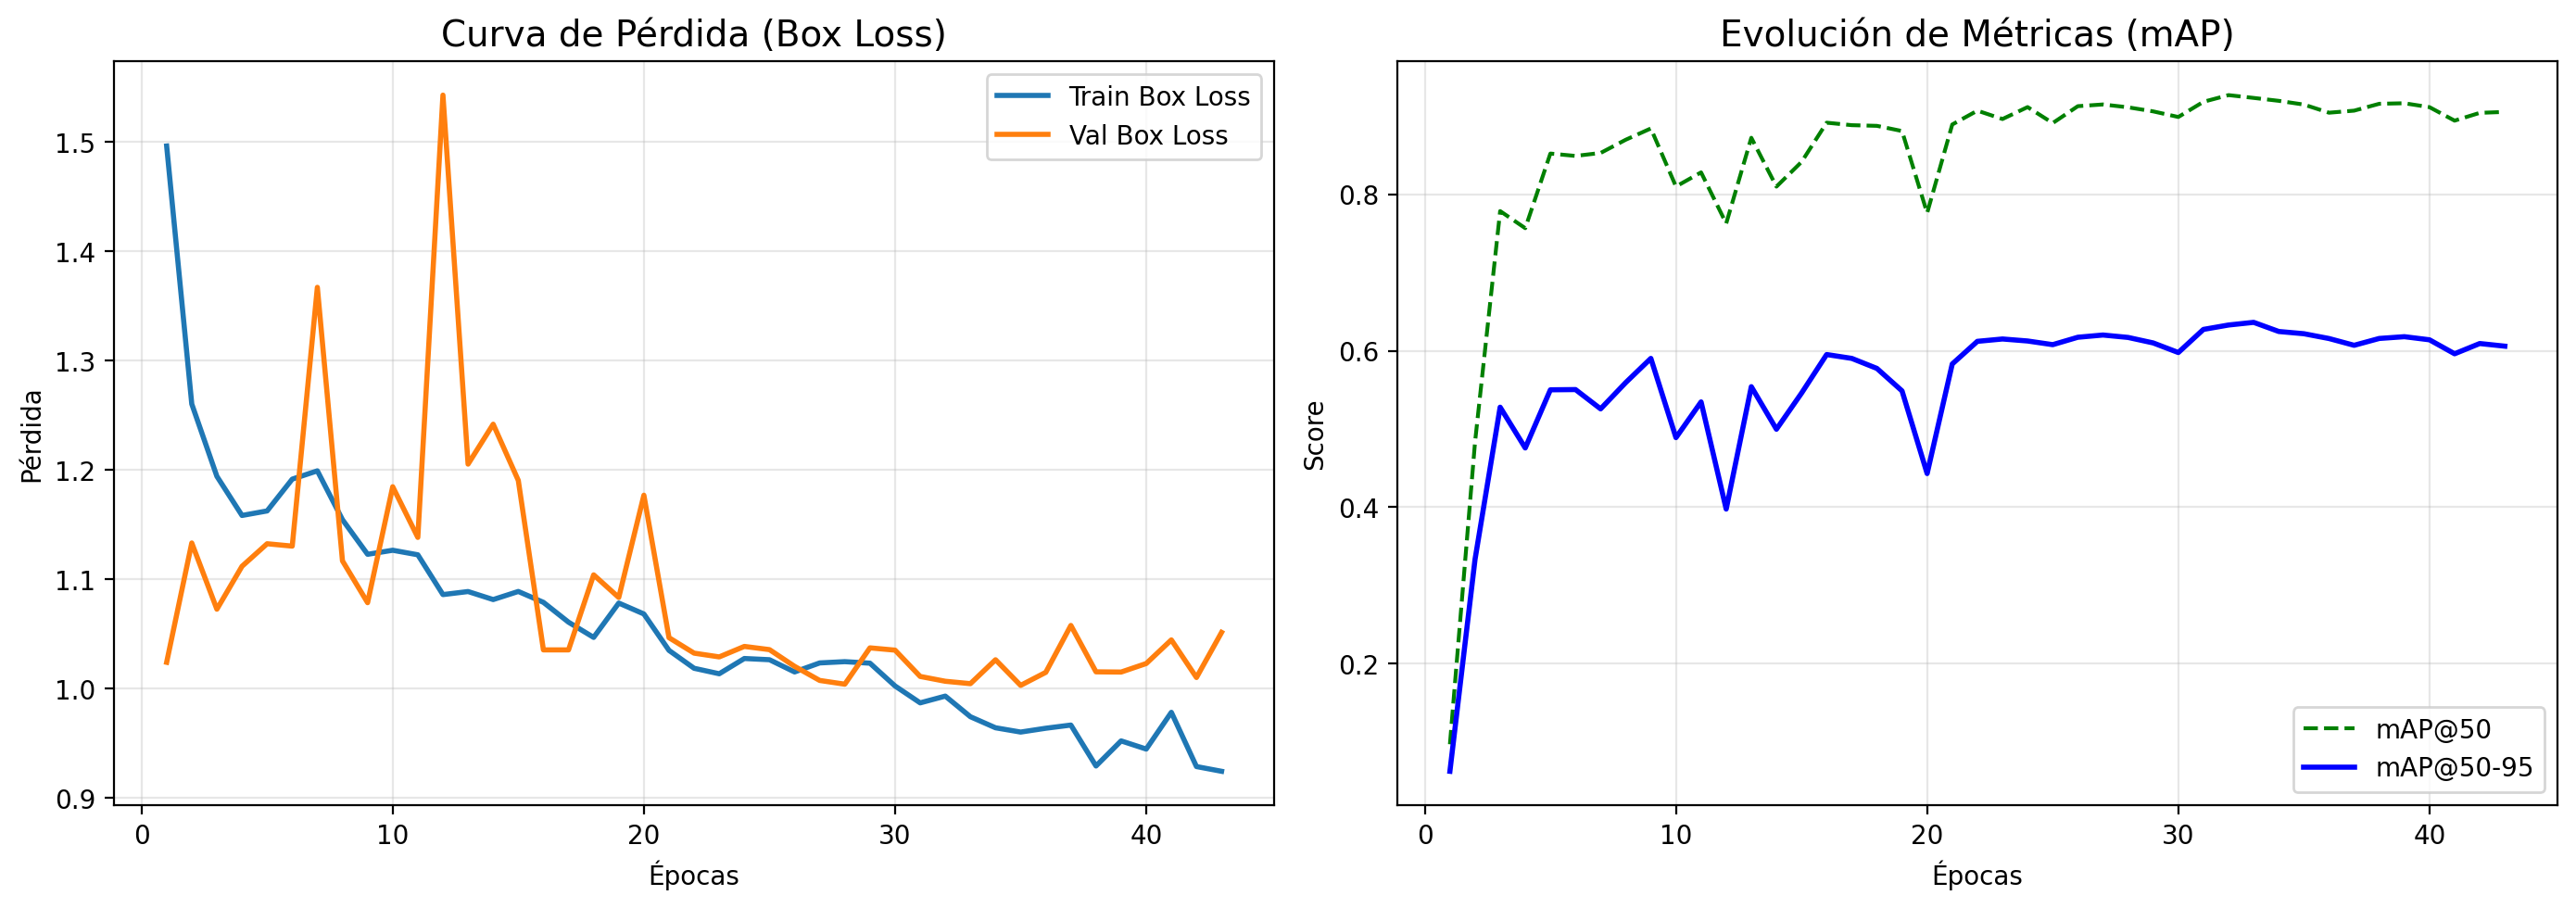

In [40]:
results_path = OUTPUT_DIR / best_run_name / "results.csv"
if not os.path.exists(results_path):
    print("No encuentro el archivo results.csv.")
else:
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

    # Creamos graficos
    plt.figure(figsize=(14, 5))

    # Curvas de Pérdida (Train vs Val)
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linewidth=2)
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linewidth=2)
    plt.title('Curva de Pérdida (Box Loss)', fontsize=14)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Métricas de Validación (mAP)
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='green', linestyle='--')
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', color='blue', linewidth=2)
    plt.title('Evolución de Métricas (mAP)', fontsize=14)
    plt.xlabel('Épocas')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Se observa una convergencia saludable donde tanto el training como el validation loss disminuyen de forma conjunta, indicando ausencia de overfitting. Aunque hubo una inestabilidad alrededor de la época 12, el modelo logró recuperarse y estabilizarse a partir de la época 25, alcanzando un mAP50-95 máximo sostenido superior a 0.63, lo que confirma que 50 épocas fueron suficientes para maximizar el rendimiento.
